In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
plt.rcParams["axes.grid"] = False
np.random.seed(101)

In [ ]:
image_path = os.path.join("/content/drive/MyDrive/TUMOR/Image")
mask_path = os.path.join("/content/drive/MyDrive/TUMOR/Mask")

In [ ]:
def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    t=0
    if flag == "test":
        for i in range(10):
            n=i+1
            t1="I"+" "+"("+str(n)+")"+".png"
            t2="M"+" "+"("+str(n)+")"+".png"
            im = cv2.resize(cv2.imread(os.path.join(image_path,t1)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,t2)),(X_shape,X_shape))[:,:,0]


            im_array.append(im)
            mask_array.append(mask)
            t+=1
            if t==20:
              break


        return im_array,mask_array

    if flag == "train":
        for i in range(80):
            n=i+1
            t1="I"+" "+"("+str(n)+")"+".png"
            t2="M"+" "+"("+str(n)+")"+".png"
            im = cv2.resize(cv2.imread(os.path.join(image_path,t1)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,t2)),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array

In [ ]:
dim=128
X_train,Y_train=getData(dim,flag="train")
X_test,Y_test=getData(dim)

In [ ]:
print(len(X_train))

80


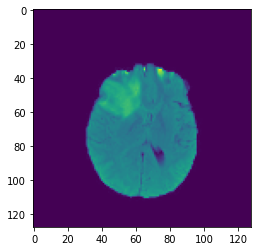

In [ ]:
plt.imshow(X_train[0])

In [ ]:
X_train = np.array(X_train).reshape(len(X_train),dim,dim,1)
y_train = np.array(Y_train).reshape(len(Y_train),dim,dim,1)
X_test = np.array(X_test).reshape(len(X_test),dim,dim,1)
y_test = np.array(Y_test).reshape(len(Y_test),dim,dim,1)
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape
images = np.concatenate((X_train,X_test),axis=0)
mask  = np.concatenate((y_train,y_test),axis=0)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(80, 128, 128, 1)
(80, 128, 128, 1)


In [ ]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [ ]:
def segnet():

    # Encoding layer
    img_input = Input(shape= (128, 128, 1))
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
    # Decoding Layer
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('sigmoid')(x)
    pred = Reshape((128,128,1))(x)

    model = Model(inputs=img_input, outputs=pred)





    return model

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='min', min_delta=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=15) # probably needs to be more patient
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
model = segnet()
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv1 (Conv2D)              (None, 128, 128, 64)      640       
                                                                 
 bn1 (BatchNormalization)    (None, 128, 128, 64)      256       
                                                                 
 activation_52 (Activation)  (None, 128, 128, 64)      0         
                                                                 
 conv2 (Conv2D)              (None, 128, 128, 64)      36928     
                                                                 
 bn2 (BatchNormalization)    (None, 128, 128, 64)      256       
                                                                 
 activation_53 (Activation)  (None, 128, 128, 64)      0   

In [ ]:
from sklearn.model_selection import train_test_split

model.compile(optimizer=Adam(lr=2e-4),
              loss=[dice_coef_loss],
           metrics = [dice_coef, 'binary_accuracy'])

train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0,
                                                            (mask>127).astype(np.float32),
                                                            test_size = 0.1,random_state = 2018)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg,
                                                            test_size = 0.1,
                                                            random_state = 2018)

loss_history = model.fit(x = train_vol,
                       y = train_seg,
                         batch_size = 16,
                  epochs = 200,
                  validation_data =(test_vol,test_seg) ,
                  callbacks=callbacks_list)



Epoch 1/200
5/5 [==============================] - ETA: 0s - loss: -0.0609 - dice_coef: 0.0613 - binary_accuracy: 0.6287
Epoch 00001: val_loss improved from -0.03794 to -0.03794, saving model to cxr_reg_weights.best.hdf5
5/5 [==============================] - 7s 717ms/step - loss: -0.0609 - dice_coef: 0.0613 - binary_accuracy: 0.6287 - val_loss: -0.0379 - val_dice_coef: 0.0379 - val_binary_accuracy: 0.9803 - lr: 2.0000e-04
Epoch 2/200
5/5 [==============================] - ETA: 0s - loss: -0.0793 - dice_coef: 0.0819 - binary_accuracy: 0.8193
Epoch 00002: val_loss did not improve from -0.03794
5/5 [==============================] - 2s 392ms/step - loss: -0.0793 - dice_coef: 0.0819 - binary_accuracy: 0.8193 - val_loss: -0.0379 - val_dice_coef: 0.0379 - val_binary_accuracy: 0.9803 - lr: 2.0000e-04
Epoch 3/200
5/5 [==============================] - ETA: 0s - loss: -0.0809 - dice_coef: 0.0806 - binary_accuracy: 0.8832
Epoch 00003: val_loss did not improve from -0.03794
5/5 [================

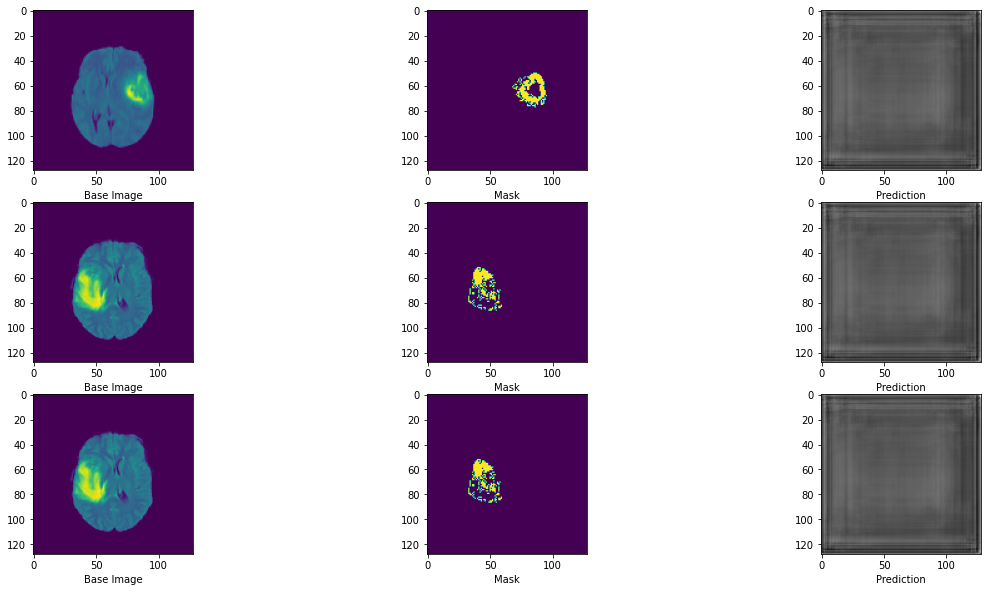

In [ ]:
pred_candidates = np.random.randint(1,validation_vol.shape[0],10)
preds = model.predict(validation_vol)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)

    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]))
    plt.xlabel("Base Image")


    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]))
    plt.xlabel("Mask")

    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]),cmap='gray')
    plt.xlabel("Prediction")

plt.savefig("output.png")

In [ ]:
###### For Demo Visualizing 1st convolutional layer output
M_conv_1=Model(inputs=model.inputs, outputs=model.layers[4].output)
M_conv_1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv1 (Conv2D)              (None, 128, 128, 64)      640       
                                                                 
 bn1 (BatchNormalization)    (None, 128, 128, 64)      256       
                                                                 
 activation_52 (Activation)  (None, 128, 128, 64)      0         
                                                                 
 conv2 (Conv2D)              (None, 128, 128, 64)      36928     
                                                                 
Total params: 37,824
Trainable params: 37,696
Non-trainable params: 128
_________________________________________________________________


In [ ]:
#############################################################################################################################

In [ ]:
def getData(X_shape, flag = "train"):
    im_array = []
    mask_array = []
    t=0
    if flag == "test":
        for i in range(10):
            n=i+1
            t1="I"+" "+"("+str(n)+")"+".png"
            t2="M"+" "+"("+str(n)+")"+".png"
            i_path=os.path.join(image_path,t1)
            m_path=os.path.join(mask_path,t1)


            img=cv2.imread(i_path,cv2.IMREAD_COLOR)
            im_array.append(img)
            mask=cv2.imread(m_path,0)
            mask_array.append(mask)
        im_array=np.array(im_array)
        mask_array=np.array(mask_array)


        return im_array,mask_array

    if flag == "train":
        for i in range(80):
            n=i+1
            t1="I"+" "+"("+str(n)+")"+".png"
            t2="M"+" "+"("+str(n)+")"+".png"
            i_path=os.path.join(image_path,t1)
            m_path=os.path.join(mask_path,t1)


            img=cv2.imread(i_path)
            im_array.append(img)
            mask=cv2.imread(m_path,0)
            mask_array.append(mask)
        im_array=np.array(im_array)
        mask_array=np.array(mask_array)

        return im_array,mask_array

In [ ]:
X_train,Y_train=getData(512)

In [ ]:
print(X_train.shape)

(80, 512, 512, 3)


In [ ]:
print(Y_train.shape)

(80,)
